# Ligonier

This notebook was used to generate some of the images in 
a blog post about Ligonier, IN.

In [82]:
from pathlib import Path
import pandas as pd
import geopandas as gpd

import matplotlib.patheffects as pe

import censusdis.data as ced
from censusdis.states import STATE_IN, STATE_MO, STATE_NY
import divintseg as dis

## Data Sources

### Diversity Data

These data files were downloaded from https://datapinions.com/diversity-and-integration-data/.
They contain demographic, diversity, and integration data for census tracts. There is one file
per state.

In [39]:
# Change DATA_DIR as needed if you stored the downloaded files 
# somewhere else.
DATA_DIR = Path.home() / 'data' / 'datapinions' / 'di'

gdf_in = gpd.read_file(DATA_DIR / '18-Indiana-2020.geojson')
gdf_ia = gpd.read_file(DATA_DIR / '19-Iowa-2020.geojson')
gdf_ne = gpd.read_file(DATA_DIR / '31-Nebraska-2020.geojson')
gdf_mo = gpd.read_file(DATA_DIR / '29-Missouri-2020.geojson')
gdf_ny = gpd.read_file(DATA_DIR / '36-New_York-2020.geojson')

### ARNOLD Road Data

ARNOLD is a set of road map data. It can be downloaded from 
https://www.bts.gov/geography/geospatial-portal/NTAD-direct-download.
The actual file we downloaded is https://geodata.bts.gov/, which we then
uncompressed in the location specified below by `ARNOLD_MAP_GDB`.

In [40]:
# Change ARNOLD_MAP_GDB as needed if you stored the downloaded
# file somewhere else.
ARNOLD_MAP_GDB = Path.home() / 'data' / 'Arnold' / 'Arnold.gdb'

gdf_arnold_in = gpd.read_file(
    ARNOLD_MAP_GDB, 
    layer=14  # Layer 14 is Indiana
)

gdf_arnold_mo = gpd.read_file(
    ARNOLD_MAP_GDB, 
    layer=25  # Layer 25 is Missouri
)

gdf_arnold_ne = gpd.read_file(
    ARNOLD_MAP_GDB, 
    layer=27  # Layer 27 is Nebraska
)


gdf_arnold_ny = gpd.read_file(
    ARNOLD_MAP_GDB, 
    layer=32  # Layer 32 is New York
)

### Census Places

In [41]:
gdf_places_in = ced.download(
    'dec/pl', 2020,
    ['NAME'],
    state=STATE_IN,
    place="*",
    with_geometry=True,
)

In [42]:
gdf_places_mo = ced.download(
    'dec/pl', 2020,
    ['NAME'],
    state=STATE_MO,
    place="*",
    with_geometry=True,
)

In [83]:
gdf_places_ny = ced.download(
    'dec/pl', 2020,
    ['NAME'],
    state=STATE_NY,
    place="*",
    with_geometry=True,
)

In [43]:
gdf_places_in.columns

Index(['STATE', 'PLACE', 'NAME', 'geometry'], dtype='object')

In [44]:
#gpd.read_file('~/Downloads/tl_2020_18_place/tl_2020_18_place.shp')

## Constructing a Neighborhood

In our nationwide analysis, we constructed a neighborhood
of all the tracts that are either a direct neighbor or the
neighbor of a neighbor of a given tract. We replicate that
logic here on a smaller scale, starting from a single 
specific tract. The purpose is to make it easier for us to
plot some visualizations for the blog post.


In [45]:
def tract_name(tract: str) -> str:
    name = tract
    
    if len(name) == 6:
        if name.endswith('00'):
            name = f'{int(name[:-2])}'
        else:
            name = f'{int(name[:-2])}.{name[-2:]}'
    
    return name

def one_tract(
    gdf_state: gpd.GeoDataFrame, 
    county: str,
    tract: str,
) -> gpd.GeoDataFrame:
    
    gdf_tract = gdf_state[(gdf_state['COUNTY'] == county) & (gdf_state['TRACT'] == tract)]
    
    return gdf_tract
    

def neighborhood2(
    gdf_state: gpd.GeoDataFrame, 
    county: str,
    tract: str,
    *,
    drop_center: bool = False
) -> gpd.GeoDataFrame:
    gdf_tract = one_tract(gdf_state, county, tract)
    
    # The tracts that are neighbors.
    gdf_neigbors_1 = gdf_state.sjoin(gdf_tract[['geometry']])
    
    # The tracts that are neighbors of neigbors.
    gdf_neigbors_2 = gdf_state.sjoin(gdf_neigbors_1[['geometry']])
    
    # Technically, what we have is all paths of length 2 from
    # the origin to other tracts, including itself. So let's drop
    # the duplicates. We only care about where we can get in two
    # steps, not the unique paths.
    gdf_neigbors_2 = gdf_neigbors_2.drop_duplicates(['STATE', 'COUNTY', 'TRACT'])
    
    # Sometimes, we don't want to include the tract we started
    # with. We just want the donut-shaped collection of tracts
    # around it.
    if drop_center:
        gdf_neigbors_2 = gdf_neigbors_2[
            (gdf_neigbors_2['COUNTY'] != county) |
            (gdf_neigbors_2['TRACT'] != tract)
        ]        
    
    return gdf_neigbors_2

def combined_neighborhood2(
    gdf_state: gpd.GeoDataFrame, 
    county: str,
    tract: str
):
    # Get all the tracts within 2 of where we started,
    # but leave a hole in the middle where we started.
    gdf_neighborhood2 = neighborhood2(gdf_state, county, tract, drop_center=True)
    
    # What are the demographic variables we should compute
    # diversity on? Leave out 'P2_001N', which is the sum
    # of the other 'P2_XXXN' counts. 
    # See https://datapinions.com/diversity-and-integration-data/
    # for more details.
    leaf_vars = [
        var for var in gdf_neighborhood2.columns 
        if (var.startswith('P2_') and var != 'P2_001N') or var.startswith('hl_')
    ]
    
    # Sum up the demographic variables, then compute diversity
    # and assemble a geo data frame around it with the geography
    # of the donut shape.
    gdf_neighborhood2_d = gpd.GeoDataFrame(
        [[f"Tracts around\n{tract_name(tract)}", dis.diversity(gdf_neighborhood2[leaf_vars].sum())]],
        columns=['TRACT', "diversity"],
        geometry=[gdf_neighborhood2.unary_union]
    )
    
    return gdf_neighborhood2_d

## Plot

In [46]:
def plot_diversity(gdf: gpd.GeoDataFrame, gdf_arnold=None, *, label: bool = False, **kwargs):
    # Plot the map.
    ax = gdf.plot(
        'diversity',
        cmap='YlOrRd',
        vmin=0.0,
        vmax=0.8,
        edgecolor='#333',
        **kwargs
    )   
    
    # If needed, clip the roads and plot them.
    if gdf_arnold is not None:
        arnold_clip = gdf.unary_union
            
        gdf_clipped_arnold = gdf_arnold.clip(arnold_clip)
    
        ax = gdf_clipped_arnold.plot(ax=ax, color='#7f7f7f7f', linewidth=0.5)
    
    if label:
        for _, row in gdf.iterrows():            
            rep = row['geometry'].representative_point()
            tract_label = tract_name(row['TRACT'])                
            ax.text(
                rep.x, rep.y, f"{tract_label}\n{100 * row['diversity']:.0f}%", ha='center', va='center',
                color='#333',
                size=9,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")]
            )
    
    
    # Make sure the area plotted is just a little bigger
    # than the data we plotted.
    bounds = gdf.total_bounds
    
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
        
    ax_xlim = ax.get_xlim()
    ax_ylim = ax.get_ylim()

    xlim = (bounds[0] - 0.05 * width, bounds[2] + 0.05 * width)
    ylim = (bounds[1] - 0.05 * height, bounds[3] + 0.05 * height)
    
    xlim = (min(xlim[0], ax_xlim[0]), max(xlim[1], ax_xlim[1]))
    ylim = (min(ylim[0], ax_ylim[0]), max(ylim[1], ax_ylim[1]))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    ax.set_axis_off()
    
    return ax

## Look Around Ligonier, IN

Let's look at the area around Ligonier, IN, and plot some maps.

In [47]:
COUNTY_LIGONIER = "113"
TRACT_LIGONIER = "972200"

In [48]:
gdf_ligonier_tract = one_tract(gdf_in, COUNTY_LIGONIER, TRACT_LIGONIER)
gdf_ligonier_neigborhood = neighborhood2(gdf_in, COUNTY_LIGONIER, TRACT_LIGONIER)

In [49]:
gdf_ligonier_place = gdf_places_in[gdf_places_in['NAME'].str.startswith('Ligonier')]

<Axes: >

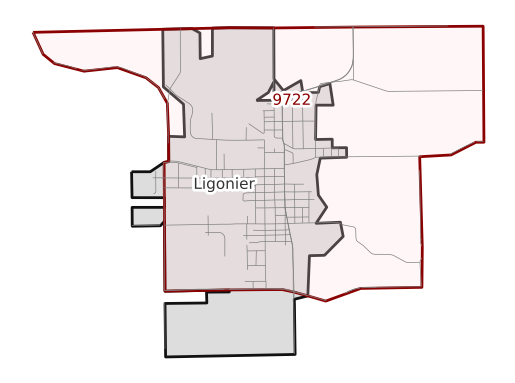

In [112]:
def plot_place_tract(
    gdf_place: gpd.GeoDataFrame,
    gdf_tract: gpd.GeoDataFrame,
    gdf_arnold: gpd.GeoDataFrame,
) :
    ax = gdf_place.plot(color='#ddd', edgecolor='#111', linewidth=2)
    ax = gdf_tract.plot(color='#ffdfdf3f', edgecolor='darkred', linewidth=2, ax=ax)

    gdf_clipped_arnold = gdf_arnold.clip(gdf_place.unary_union.union(gdf_tract.unary_union))

    ax = gdf_clipped_arnold.plot(ax=ax, color='#7f7f7f', linewidth=0.5)

    for _, row in gdf_place.iterrows():
        rep = row['geometry'].representative_point()

        ax.text(
            rep.x, rep.y, f"{row['NAME'].split(' ')[0]}", ha='center', va='center',
            color='#333',
            size=11,
            path_effects=[pe.withStroke(linewidth=4, foreground="white")]
        )

    for _, row in gdf_tract.iterrows():
        rep = row['geometry'].representative_point()
        bounds = row['geometry'].bounds

        ax.text(
            rep.x, (rep.y + bounds[3]) / 2, tract_name(row['TRACT']), ha='center', va='center',
            color='darkred',
            size=11,
            path_effects=[pe.withStroke(linewidth=4, foreground="white")]
        )

    ax.set_axis_off()
    
    return ax

plot_place_tract(gdf_ligonier_place, gdf_ligonier_tract, gdf_arnold_in)

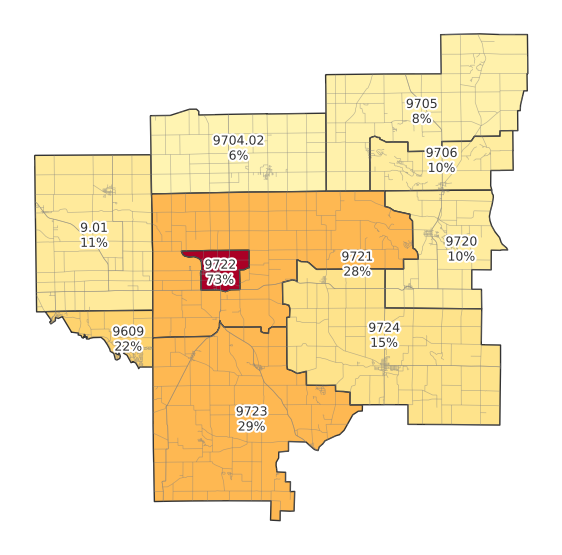

In [51]:
ax = plot_diversity(gdf_ligonier_neigborhood, gdf_arnold_in, label=True, figsize=(7, 7))

In [52]:
gdf_ligonier = one_tract(gdf_in, COUNTY_LIGONIER, TRACT_LIGONIER)
gdf_ligonier_donut = combined_neighborhood2(gdf_in, COUNTY_LIGONIER, TRACT_LIGONIER)

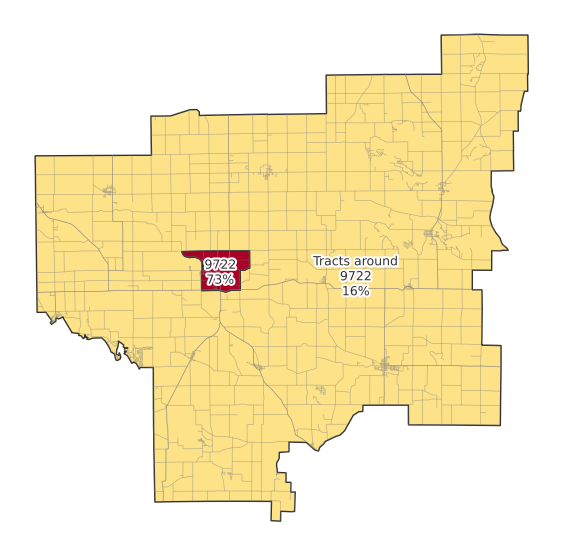

In [53]:
ax = plot_diversity(gdf_ligonier_donut, gdf_arnold_in, label=True, figsize=(7, 7))
ax = plot_diversity(gdf_ligonier, gdf_arnold_in, label=True, ax=ax)

## Crete, NE

Similar analysis looking around Crete, NE

In [54]:
COUNTY_CRETE = "151"
TRACT_CRETE_1 = "960601"
TRACT_CRETE_2 = "960602"

In [55]:
gdf_crete_1 = one_tract(gdf_ne, COUNTY_CRETE, TRACT_CRETE_1)
gdf_crete_2 = one_tract(gdf_ne, COUNTY_CRETE, TRACT_CRETE_2)
gdf_crete_neighborhood_1 = neighborhood2(gdf_ne, COUNTY_CRETE, TRACT_CRETE_1)
gdf_crete_neighborhood_2 = neighborhood2(gdf_ne, COUNTY_CRETE, TRACT_CRETE_2)

gdf_crete_donut_1 = combined_neighborhood2(gdf_ne, COUNTY_CRETE, TRACT_CRETE_1)
gdf_crete_donut_2 = combined_neighborhood2(gdf_ne, COUNTY_CRETE, TRACT_CRETE_2)

gdf_crete_donut_1

,TRACT,diversity,geometry
0,Tracts around\n9606.01,0.250344,"POLYGON ((-97.36914 40.11085, -97.36917 40.124..."


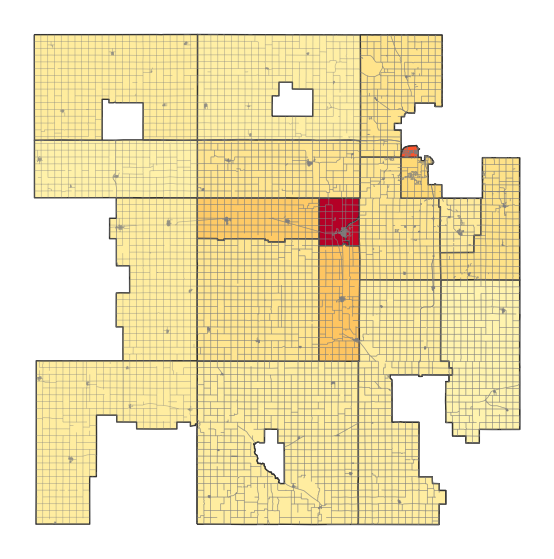

In [56]:
ax = plot_diversity(gdf_crete_neighborhood_1, gdf_arnold_ne, figsize=(7, 7))
ax = plot_diversity(gdf_crete_neighborhood_2, gdf_arnold_ne, ax=ax)

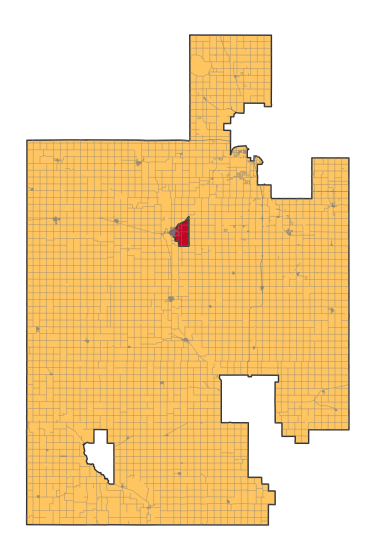

In [57]:
ax = plot_diversity(gdf_crete_donut_1, gdf_arnold_ne, figsize=(7, 7))
ax = plot_diversity(gdf_crete_1, gdf_arnold_ne, ax=ax)

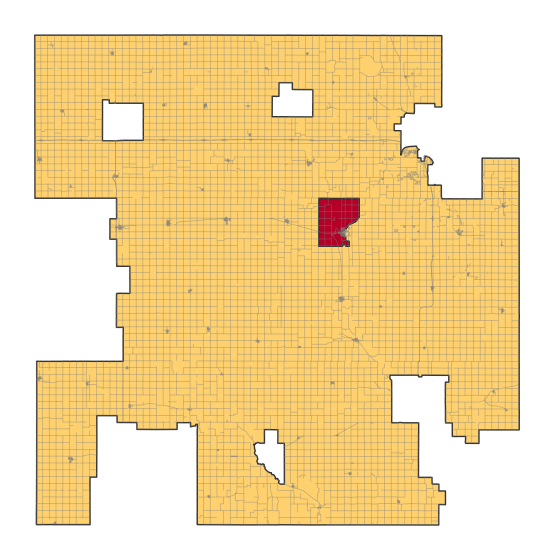

In [58]:
ax = plot_diversity(gdf_crete_donut_2, gdf_arnold_ne, figsize=(7, 7))
ax = plot_diversity(gdf_crete_2, gdf_arnold_ne, ax=ax)

### Milan, MO

In [59]:
COUNTY_MILAN = "211"
TRACT_MILAN = "480300"

In [60]:
gdf_milan_tract = one_tract(gdf_mo, COUNTY_MILAN, TRACT_MILAN)
gdf_milan_neigborhood = neighborhood2(gdf_mo, COUNTY_MILAN, TRACT_MILAN)

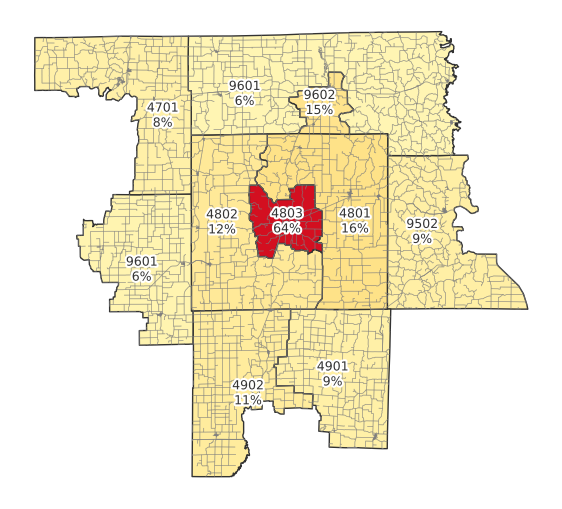

In [61]:
ax = plot_diversity(gdf_milan_neigborhood, gdf_arnold_mo, label=True, figsize=(7, 7))

In [62]:
gdf_milan = one_tract(gdf_mo, COUNTY_MILAN, TRACT_MILAN)
gdf_milan_donut = combined_neighborhood2(gdf_mo, COUNTY_MILAN, TRACT_MILAN)

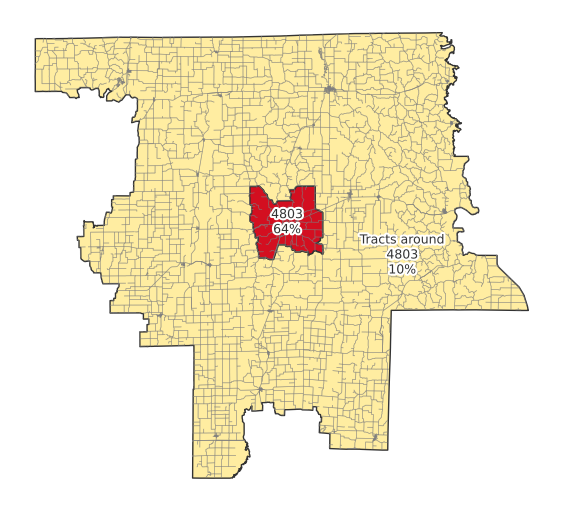

In [63]:
ax = plot_diversity(gdf_milan_donut, gdf_arnold_mo, label=True, figsize=(7, 7))
ax = plot_diversity(gdf_milan, gdf_arnold_mo, label=True, ax=ax)

In [64]:
gdf_milan_place = gdf_places_mo[gdf_places_mo['NAME'].str.startswith('Milan')]

<Axes: >

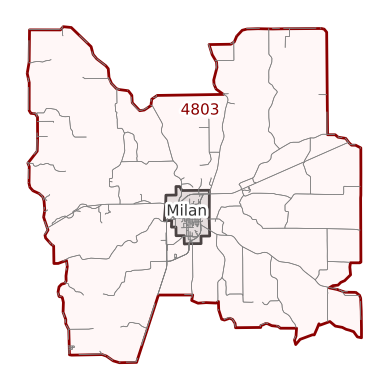

In [80]:
plot_place_tract(gdf_milan_place, gdf_milan, gdf_arnold_mo)

### Oneida County, New York

In [66]:
COUNTY_MID_STATE = "065"
TRACT_MID_STATE = "026600"

In [67]:
gdf_mid_state_tract = one_tract(gdf_ny, COUNTY_MID_STATE, TRACT_MID_STATE)
gdf_mid_state_neigborhood = neighborhood2(gdf_ny, COUNTY_MID_STATE, TRACT_MID_STATE)

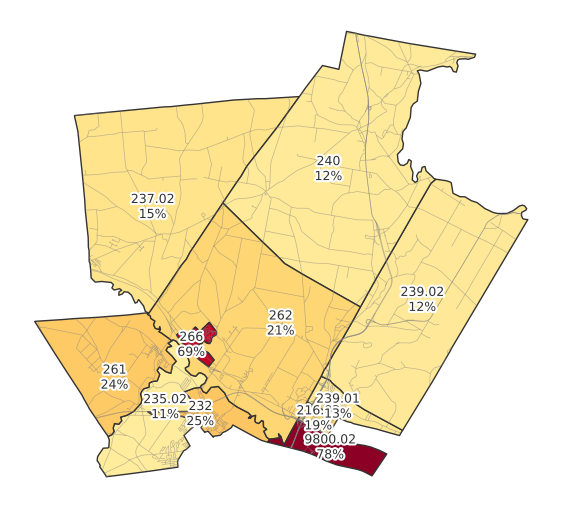

In [68]:
ax = plot_diversity(gdf_mid_state_neigborhood, gdf_arnold_ny, label=True, figsize=(7, 7))

In [69]:
gdf_mid_state = one_tract(gdf_ny, COUNTY_MID_STATE, TRACT_MID_STATE)
gdf_mid_state_donut = combined_neighborhood2(gdf_ny, COUNTY_MID_STATE, TRACT_MID_STATE)

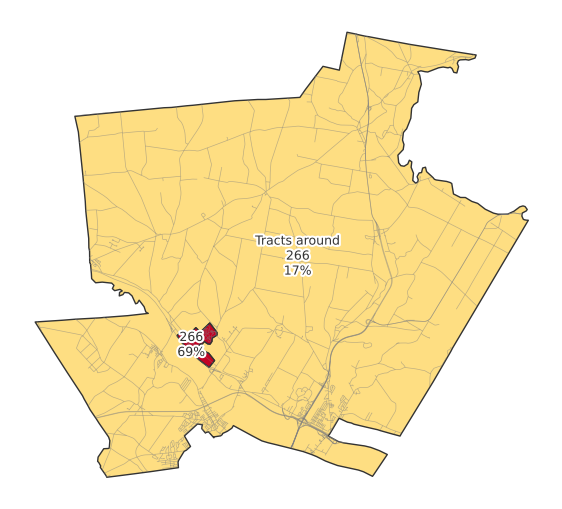

In [70]:
ax = plot_diversity(gdf_mid_state_donut, gdf_arnold_ny, label=True, figsize=(7, 7))
ax = plot_diversity(gdf_mid_state, gdf_arnold_ny, label=True, ax=ax)

In [109]:
mid_state_bounds = gdf_mid_state_tract.total_bounds
mid_state_area_bounds = [
    mid_state_bounds[0] - 0.02,
    mid_state_bounds[1] - 0.02,
    mid_state_bounds[2] + 0.02,
    mid_state_bounds[3] + 0.02,
]

In [110]:
gdf_mid_state_place = gdf_places_ny.cx[
    mid_state_area_bounds[0]:mid_state_area_bounds[2],
    mid_state_area_bounds[1]:mid_state_area_bounds[3]
]

<Axes: >

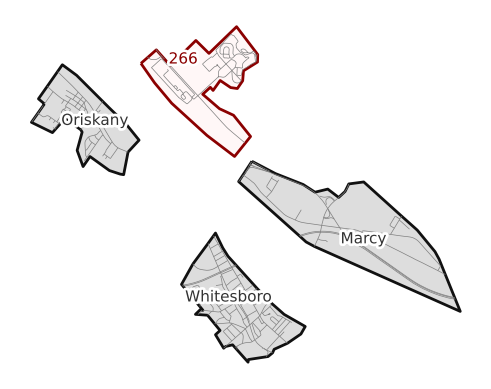

In [113]:
plot_place_tract(gdf_mid_state_place, gdf_mid_state, gdf_arnold_ny)